In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import skew, kurtosis, norm
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.preprocessing import quantile_transform
import psutil
%matplotlib inline

In [177]:
# Rewrite HDBSCAN pipeline to segment dataset into batches and process batches individually.

# Begin by batching dataset.

n_batches = 300

hit_params = np.load('/datax/scratch/benjb/C23_L_full_param_array.npy', allow_pickle=True)
stg_params = np.load('/datax/scratch/benjb/C23_L_full_injected_params.npy', allow_pickle=True)

#plt.hist(hit_params[:,1], bins=50)
#plt.show()

print(hit_params.shape)
print(stg_params.shape)

full_params = np.vstack((hit_params, stg_params)) # need to be preprocessed together for quantile transforms

freqs = full_params[:,0]
drifts = full_params[:,1]

#save_freqs = np.copy(freqs)[:-10]
#save_drifts = np.copy(drifts)[:-10]

# quantile transform drifts -> Gaussian
normal_drifts = quantile_transform(drifts.reshape(len(drifts), 1), n_quantiles=100000, 
                                   output_distribution='normal', subsample=100000)
normal_drifts = normal_drifts.reshape(len(normal_drifts))

full_params[:,0] = np.argsort(np.argsort(freqs))/len(freqs) # quantile transform freqs -> uniform
full_params[:,1] = normal_drifts

# separate injected hits again so they can be re-injected into each batch later
hit_params = full_params[:-10]
stg_params = full_params[-10:]

#plt.hist(stg_params[:,1])
#plt.show()

batch_size = len(hit_params) // n_batches

hit_batches = []

np.random.shuffle(hit_params) # shuffle hits before batching

for i in range(n_batches):

    if i != n_batches-1:
        batch = hit_params[i*batch_size:(i+1)*batch_size]
    else:
        batch = hit_params[i*batch_size:] # catch the last few entries in the final batch
                                          # (only 1 extra in my dataset, but might need
                                          # to be more evenly split in other work)

    #print(batch.shape)
    hit_batches.append(batch)

(2185987, 12)
(10, 12)


In [153]:
print(hit_batches[0].shape)

(4968, 12)


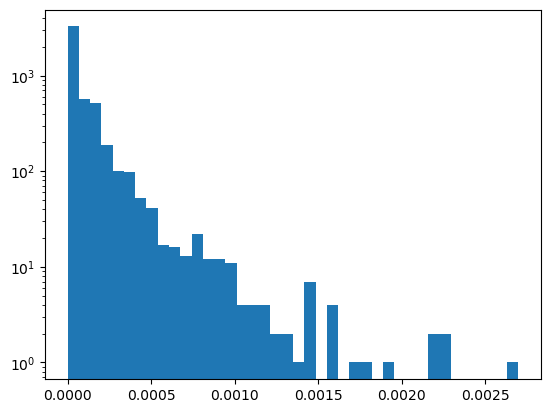

In [168]:
plt.hist(hit_batches[0][:,11], bins=40)
plt.yscale('log')
plt.show()

In [178]:
def preprocess(batch):

    freqs = batch[:,0]
    drifts = batch[:,1]
    snrs = batch[:,2]
    skews = batch[:,3]
    kurts = batch[:,4]
    sarles = batch[:,5]
    corrs = batch[:,6]
    tbws = batch[:,7]
    tskews = batch[:,8]
    tstds = batch[:,9]
    fstds = batch[:,10]
    sigbws = batch[:,11]

    #normal_drifts = quantile_transform(drifts.reshape(len(drifts), 1), 
    #                               output_distribution='normal')
    #normal_drifts = normal_drifts.reshape(len(normal_drifts))

    #print(freqs.shape)
    #print(drifts.shape)

    data_arr = np.array([freqs,
                        #0.1*(freqs-np.min(freqs))/np.max(freqs-np.min(freqs)), 
                        np.abs(drifts)/np.max(np.abs(drifts)), 
                        (np.log10(snrs)-np.min(np.log10(snrs)))/np.max(np.log10(snrs)-np.min(np.log10(snrs))), 
                        (skews-np.min(skews))/np.max((skews-np.min(skews))), 
                        (np.log10(kurts)-np.min(np.log10(kurts)))/np.max(np.log10(kurts)-np.min(np.log10(kurts))), 
                        sarles, 
                        corrs, 
                        (np.log10(tbws*1e6)-np.min(np.log10(tbws*1e6)))/np.max(np.log10(tbws*1e6)-np.min(np.log10(tbws*1e6))),
                        (tskews-np.min(tskews))/np.max((tskews-np.min(tskews))),
                        (np.log10(tstds)-np.min(np.log10(tstds))),
                        (np.log10(fstds)-np.min(np.log10(fstds))),
                        sigbws/np.max(sigbws)
                        ])  ### PRE-PROCESSED FOR HDBSCAN

    data_arr_unscaled = np.array([freqs, 
                        drifts, 
                        snrs, 
                        skews, 
                        kurts, 
                        sarles, 
                        corrs, 
                        tbws*1e6, # units of Hz
                        tskews,
                        tstds,
                        fstds,
                        sigbws*1e6 # units of Hz
                        ])

    return data_arr, data_arr_unscaled

In [179]:
def batch_hdbscan(batch_arr_scaled, nmincluster, nminsamples, eps):

    hdb = HDBSCAN(
        min_cluster_size=nmincluster, 
        min_samples=nminsamples, 
        cluster_selection_epsilon=eps, 
        #metric = 'haversine',
        leaf_size=100,
        n_jobs=10,
        cluster_selection_method='eom')
    
    X = np.transpose(batch_arr_scaled)
    hdb.fit(X)

    labels_list = hdb.labels_

    return labels_list

In [180]:
nmincluster = 7
nminsamples = 2
eps = 0.0

bbb = np.vstack((hit_batches[0], stg_params))
print(bbb.shape)
bbb_scaled, bbb_unscaled = preprocess(bbb)

#plt.hist(bbb_scaled[0], bins=50)
#plt.yscale('log')
#plt.show()

print(bbb_scaled.shape)
print(bbb_unscaled.shape)

labels_list = batch_hdbscan(bbb_scaled, nmincluster, nminsamples, eps)

print(np.unique(labels_list))
print(labels_list[-10:])
print(len(np.where(labels_list==-1)[0]))
print(len(np.where(labels_list==-1)[0])/len(labels_list))
print(len(np.where(labels_list==len(np.unique(labels_list))-3)[0])/len(labels_list))

(7296, 12)
(12, 7296)
(12, 7296)
[-1  0  1]
[ 1  1 -1  1  1  1  1  1  0  1]
22
0.0030153508771929823
0.9958881578947368


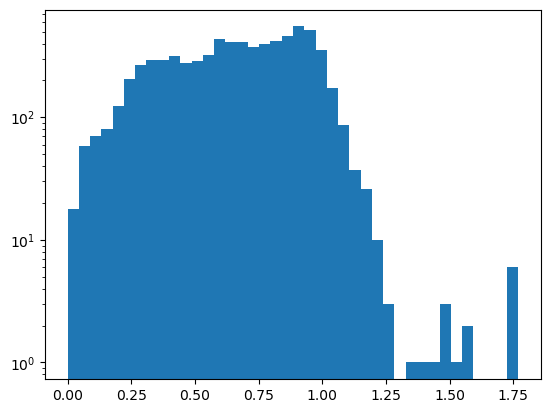

In [193]:
plt.hist(bbb_scaled[10], bins=40)
plt.yscale('log')
plt.show()

In [174]:
print(np.unique(labels_list))
print(labels_list[-10:])
print(len(np.where(labels_list==-1)[0]))
print(len(np.where(labels_list==-1)[0])/len(labels_list))
print(len(np.where(labels_list==len(np.unique(labels_list))-3)[0])/len(labels_list))

[-1  0  1]
[-1 -1 -1 -1 -1 -1 -1  0  0  0]
51
0.010245078344716753
0.9865407794294897


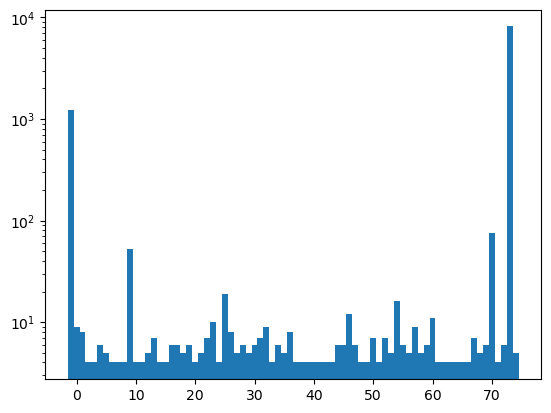

In [99]:
plt.hist(labels_list, bins=len(np.unique(labels_list)), range=[-1.5, np.max(np.unique(labels_list))+0.5])
plt.yscale('log')
plt.show()

[-1  0  1]
Scattering ...
Refining ...


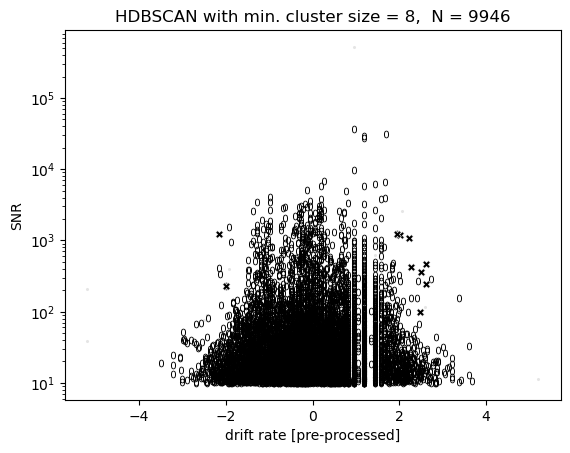

In [108]:
col_idx_x = 1
col_idx_y = 2

df = pd.DataFrame(np.transpose(bbb_scaled),
                   columns=['frequency [MHz]', 
                            'drift rate [Hz/s]', 
                            'log10 SNR', 
                            'skewness', 
                            'log10 kurtosis', 
                            'Sarle\'s coefficient', 
                            'correlation coefficient [kurtosis vs. log(bandwidth)]', 
                            'log10 turning-point bandwidth [Hz]', 
                            'temporal skewness', 
                            'log10 time-series standard deviation', 
                            'log10 power-spectrum standard deviation',
                            'signal bandwidth [Hz]'])

dfu = pd.DataFrame(np.transpose(bbb_unscaled),
                   columns=['frequency [pre-processed]', 
                            'drift rate [pre-processed]', 
                            'SNR', 
                            'spectral skewness', 
                            'spectral kurtosis', 
                            'Sarle\'s coefficient', 
                            'correlation coefficient [kurtosis vs. log(bandwidth)]', 
                            'turning-point bandwidth [Hz]', 
                            'temporal skewness', 
                            'time-series standard deviation', 
                            'power-spectrum standard deviation',
                            'signal bandwidth [Hz]'])

labels = np.unique(labels_list)
print(labels)

x_param = dfu.columns[col_idx_x]
y_param = dfu.columns[col_idx_y]

x = dfu[x_param].values
y = dfu[y_param].values

colors = cm.nipy_spectral(np.linspace(0, 1, len(labels)-1))

print('Scattering ...')
for l in labels[::-1]:
    idxs = np.where(labels_list == l)[0]
    if l == -1.:
        plt.scatter(x[idxs], y[idxs], color='k', s=5, alpha=0.1, linewidths=0, label=f'n={len(idxs)}')
    else:
        plt.scatter(x[idxs], y[idxs], marker=f'${l}$', color=colors[l], s=30, linewidths=0, label=f'n={len(idxs)}')

#other_idxs = np.array([3068, 3069, 3070])
plt.scatter(x[-10:], y[-10:], color='k', edgecolors='w', linewidths=0.4, s=30, marker='X')

print('Refining ...')

if 'log10' in df.columns[col_idx_x]:
    plt.xscale('log')
else:
    plt.xscale('linear')
if 'log10' in df.columns[col_idx_y]:
    plt.yscale('log')
else:
    plt.yscale('linear')

plt.xlabel(x_param)
plt.ylabel(y_param)
plt.title(f'HDBSCAN with min. cluster size = {nmincluster},  N = {len(x)}')

#leg = plt.legend(fontsize=8)
#for lh in leg.legendHandles: 
#    lh.set_alpha(1)
#    lh.set_sizes([30])
#plt.xscale('log')
#plt.yscale('log')

#plt.savefig(f'HDBSCAN_clustering_{col_idx_x}_{col_idx_y}.pdf')

plt.show()